# Data analysis of skeletal muscle area and SMI for normal patients

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

###### Load libraries and directories

In [2]:
# from IPython import get_ipython
from IPython.display import display, HTML
#from tqdm.notebook import tqdm
import pickle
import os
import pprint
pp = pprint.PrettyPrinter(indent=1)

import pandas as pd
import numpy as np

import json

# Custom functions
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):        
    with open(filename, 'rb') as input:
        return pickle.load(input)
    

In [3]:
# Install statsmodels if it doesn't exist
import pip
def import_or_install(package):
    try:
        return __import__(package)
    except ImportError:
        pip.main(['install', package]) 
        
packages = ['statsmodels','matplotlib','scipy','pygrowup','sklearn','cv2']

for package in packages:
    import_or_install(package)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ji60cjcb because the default path (/home/jupyteruser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement cv2
ERROR: No matching distribution found for cv2
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats
get_ipython().run_line_magic('tb', '')

generated new fontManager


No traceback available to show.


In [5]:
cwd = os.getcwd()
print(cwd)

/home/jupyteruser/smipipeline


In [6]:
data = '/home/jupyteruser/data'
pickles = '/home/jupyteruser/pickles'
models = '/home/jupyteruser/models'
output = '/home/jupyteruser/output/results_cdc85'

In [7]:
# Import modules and config file
configfile = os.path.join(cwd,'config/debug_ES/run_prediction_CV_poorl3.json')
with open(configfile, "r") as f:
        config = json.load(f)
pp.pprint(config)

{'l3_finder': {'cache_dir': '/tf/_cache/',
               'cache_intermediate_results': True,
               'dicom_dir': '/tf/data',
               'model_path_dir': '/tf/models/l3/cv_final',
               'new_tim_dicom_dir_structure': True,
               'output_directory': '/tf/output/cv_poorl3/l3',
               'overwrite': True,
               'save_plots': True,
               'show_plots': False},
 'muscle_segmentor': {'model_path_dir': '/tf/models/muscle/cv_final',
                      'output_directory': '/tf/output/cv_poorl3/ms'}}


In [8]:
for key in config.keys():
    for label, value in config[key].items():
        if type(value) is str:
            config[key][label] = value.replace('/tf', '/home/jupyteruser')

pp.pprint(config)

{'l3_finder': {'cache_dir': '/home/jupyteruser/_cache/',
               'cache_intermediate_results': True,
               'dicom_dir': '/home/jupyteruser/data',
               'model_path_dir': '/home/jupyteruser/models/l3/cv_final',
               'new_tim_dicom_dir_structure': True,
               'output_directory': '/home/jupyteruser/output/cv_poorl3/l3',
               'overwrite': True,
               'save_plots': True,
               'show_plots': False},
 'muscle_segmentor': {'model_path_dir': '/home/jupyteruser/models/muscle/cv_final',
                      'output_directory': '/home/jupyteruser/output/cv_poorl3/ms'}}


## Produce data for analysis using prediction results and preprocessing results

In [9]:
# Load the area csv
filename = 'areas-mm2_by_subject_id_manualarea_for_outliers.csv'
#filename = 'areas-mm2_by_subject_id.csv'


sma_csv = os.path.join(config["muscle_segmentor"]["output_directory"],filename)
df_sma = pd.read_csv(sma_csv, index_col=False)

In [10]:
if 'outliers' in filename: # MOdified area sheet with manual area calculated for outlier patients
    display(df_sma.head(10))
    df_sma_manuals = df_sma.loc[~df_sma['area_mm2_Elan'].isnull()]
    for i,row in df_sma_manuals.iterrows():
        df_sma.loc[df_sma['subject_id']==row['subject_id'],'area_mm2'] = row['area_mm2_Elan']
    

# Manually identified diseases cases [by Andrew]:
man_disease = ['Z832424','Z1256768']

df_sma= df_sma.loc[~df_sma['subject_id'].isin(man_disease)]
df_sma = df_sma[['subject_id','area_mm2','sagittal_series','axial_series']]
print('Final patients for analysis: ',len(df_sma))

,subject_id,area_mm2,% auto mask pixels,% manual mask pixels,area_mm2_Elan,sagittal_series,axial_series
0,Z862651,15337.387500,NaN,NaN,NaN,Z862651-SE-10-Bone_Sagittal_Bone_Bone_3.0,Z862651-SE-5-Std_Axial_Body_Std_5.0
1,Z1310189,5194.947664,NaN,NaN,NaN,recon from: Z1310189-SE-4-Std_Axial_Body_Std_5.0,Z1310189-SE-4-Std_Axial_Body_Std_5.0
2,Z1452514,10329.928960,NaN,NaN,NaN,Z1452514-SE-9-Bone_Sagittal_Bone_Bone_3.0,Z1452514-SE-4-Std_Axial_Body_Std_5.0
3,Z1178360,7812.500000,NaN,NaN,NaN,recon from: Z1178360-SE-4-Body_5.0_CE,Z1178360-SE-4-Body_5.0_CE
4,Z1244498,4626.782208,NaN,NaN,NaN,Z1244498-SE-7-Bone_Sagittal_3.000,Z1244498-SE-2-Body_5.0
5,Z514679,15866.068320,NaN,NaN,NaN,Z514679-SE-11-Bone_Sagittal_3.000,Z514679-SE-5-Body__5.0
6,Z617099,10991.944600,NaN,NaN,NaN,recon from: Z617099-SE-3-Body,Z617099-SE-3-Body
7,Z437139,9915.643712,NaN,NaN,NaN,recon from: Z437139-SE-3-Pediatric_Std_5.0,Z437139-SE-3-Pediatric_Std_5.0
8,Z597267,6663.738276,NaN,NaN,NaN,recon from: Z597267-SE-4-Std_Axial_Body_Std_5.0,Z597267-SE-4-Std_Axial_Body_Std_5.0
9,Z1106026,6036.252768,NaN,NaN,NaN,Z1106026-SE-5-Sagittal_Body,Z1106026-SE-1002-Body_Clarity


Final patients for analysis:  1362


In [11]:
# change subject_id to id
df_sma.columns=['ID','area_mm2','sagittals','axials']
#display(df_sma.head(2))

In [12]:
# Load the df_final pickle
df_final_d1 = load_object(os.path.join(pickles,'df_final_dump1_processed.pkl'))
#print('dump 1 length = ',len(df_final_d1))
df_final_d2 = load_object(os.path.join(pickles,'df_final_dump2_processed.pkl'))
#print('dump 2 length = ',len(df_final_d2))

In [13]:
# Merge the  2 dumps
df_final = df_final_d1.append(df_final_d2)
print('Total processed final length (iteration 1, more patients were filtered in iteration 2 (more search terms)) = ',len(df_final))

Total processed final length (iteration 1, more patients were filtered in iteration 2 (more search terms)) =  2367


In [14]:
# Create the dataframe for analysis by merging df_sma with df_final
# Replace axial and sagittal series in df_final with df_sma that has 
# pointers to reconstructed sagittals, preserve the other fields.
df_final = df_final.drop(columns=['Axial','Sagittal'])
#display(df_final.head(10))

In [15]:
# Make sure both dfs are equal length
#print('Sma len: ', len(df_sma))
#print('Final len: ', len(df_final))

In [16]:
# 25 cases failed because of L3 level was out of bound, get rid of those for now:
df_final = df_final[df_final['ID'].isin(df_sma['ID'].values)]
print('No of patients processed successfully: ', len(df_final))

No of patients processed successfully:  1362


In [17]:
# Now merge on ID
df_analysis = pd.merge(df_sma,df_final, on="ID")
#display(df_analysis.head(10))

In [18]:
# Load age information from patlist csv
# Load normal patient list
infile  = 'patlist_with_validBMI_CDC85_corrected.csv'
df_P = pd.read_csv(infile, index_col=False)
df_P = df_P.loc[:, ~df_P.columns.str.contains('^Unnamed')]
# Keep only columns needed
df_P = df_P[['PAT_ID','WEIGHT','HEIGHT','BMI_FOR_AGE_PERCENTILE','BMI_CALCULATED','Age',
 'Sex',
 'Race',
 'AgeGroup']]
df_P.columns = ['ID','WEIGHT','HEIGHT','BMI_AGE_P','BMI_CALC','Age','Sex','Race','AgeGroup']
#display(df_P.head(10))

In [19]:
# Get rid of patients not in df_analysis
print("Total number of normal patients identified", len(df_P))
df_P = df_P[df_P['ID'].isin(df_analysis['ID'].values)]
print("Total number of normal patients with images", len(df_P))

Total number of normal patients identified 1090
Total number of normal patients with images 1022


In [20]:
# Merge the patient fields with df_analysis
df_analysis = pd.merge(df_P,df_analysis, on="ID")

print('Length of final analysis df: ', len(df_analysis))

# Redefine AgeGroup be flooring instead of rounding.
df_analysis['AgeGroup'] = np.floor(df_analysis['Age'].values)

Length of final analysis df:  1022


In [21]:
# Manual L3 check
infile  = 'poorl3.csv'
df_poorl3 = pd.read_csv(infile, index_col=False)

l3_present = df_poorl3.loc[~df_poorl3['L3slice'].isnull(),'ID'].values.tolist()
print('Cases with manually identified L3s: ', len(l3_present))

Cases with manually identified L3s:  30


In [22]:
# This was used to filter exams for prediction in run_prediction_cv
# normal_patients_corrected = df_analysis.ID.values.tolist()
# print(len(normal_patients_corrected))
# save_object(normal_patients_corrected,os.path.join(pickles,'normal_patients_corrected.pkl'))

In [23]:
l3_present_analysis = [l3 for l3 in l3_present if l3 in df_analysis.ID.values]
print('Normal L3s that are valid: ', len(l3_present_analysis))
for l3 in l3_present_analysis:
    print(l3)

Normal L3s that are valid:  13
Z418856
Z670302
Z1029886
Z1302641
Z627309
Z1722108
Z5745
Z489517
Z1332420
Z1263347
Z320930
Z1221549
Z1119985


In [24]:
# Find missing BMI_CALC
print('Patients missing BMI calculated:' ,len(df_analysis[df_analysis['BMI_CALC'].isnull()]))
print('Patients missing BMI age percentile:' ,len(df_analysis[df_analysis['BMI_AGE_P'].isnull()]))
print('Patients missing Height:' ,len(df_analysis[df_analysis['HEIGHT'].isnull()]))
print('Patients missing Weight' ,len(df_analysis[df_analysis['WEIGHT'].isnull()]))
print('Patients missing Age' ,len(df_analysis[df_analysis['Age'].isnull()]))
print('Patients missing Race' ,len(df_analysis[df_analysis['Race'].isnull()]))
print('Patients missing Sex' ,len(df_analysis[df_analysis['Sex'].isnull()]))

Patients missing BMI calculated: 95
Patients missing BMI age percentile: 0
Patients missing Height: 10
Patients missing Weight 22
Patients missing Age 0
Patients missing Race 0
Patients missing Sex 0


In [25]:
df_analysis = df_analysis.sort_values(by=['AgeGroup'],ascending='False')
#print(df_analysis['AgeGroup'].value_counts().sort_values())

In [26]:
# Patients > 18
print('No of Patients > 18 years that are discarded' ,len(df_analysis[df_analysis['AgeGroup'] > 18]))
#print('No of Patients < 2.5 yearas' ,len(df_analysis[df_analysis['Age'] < 2.5]))

No of Patients > 18 years that are discarded 1


In [27]:
#print('No of boys' ,len(df_analysis[df_analysis['Sex'] == 'Male']))
#print('No of girls' ,len(df_analysis[df_analysis['Sex'] == 'Female']))

In [28]:
# Create sex stratified and age filtered dfs

df_analysis['area_cm2'] = df_analysis['area_mm2']/100


df_analysis['smi'] = df_analysis['area_cm2']/((df_analysis['HEIGHT']/100)**2)

df_m = df_analysis[(df_analysis['Sex']=='Male') & (df_analysis['AgeGroup'] <= 18)] #& (df_analysis['Age'] > 3)]
print('Length of male df = ',len(df_m))
df_f = df_analysis[(df_analysis['Sex']=='Female') & (df_analysis['AgeGroup'] <= 18)] # & (df_analysis['Age'] > 3)]
print('Length of female df = ',len(df_f))

Length of male df =  505
Length of female df =  516


In [29]:
674/699

0.9642346208869814

## Population statistics in comparison to CDC/WHO data

In [30]:
#Step3: Loop over each unique date in the studies dataframe df_F
def get_agewise_stats(df_in):
    uniqueages = df_in.AgeGroup.unique() 
    column_names = ['AgeGroup','Age_IQR','median_area_cm2','median_SMI','samplesize']
    df_C = pd.DataFrame(columns = column_names)
    #display(df_C)
    for age in uniqueages:
        df_l = df_in[df_in['AgeGroup']==age]
        #mean_ar = np.mean(df_l['area_cm2'])
        median_ar = np.median(df_l['area_cm2'])
        median_SMI = np.nanmedian(df_l['smi'])
        q75, q25 = np.percentile(df_l['Age'], [75 ,25])
        age_iqr = q75 - q25
        samplesize = len(df_l)
        #print([age,mean_ar,median_ar,samplesize])
        df = pd.DataFrame([[age,age_iqr,median_ar,median_SMI,samplesize]],columns=column_names)
        #display(df)
        df_C = pd.concat([df_C,df])
    return df_C

In [31]:
print('Count statistics stratified by gender and age group')
print('(M - Male) (F-Female)')    
df_f_agestats = get_agewise_stats(df_f).add_suffix('_F')
df_m_agestats = get_agewise_stats(df_m).add_suffix('_M')

display(pd.concat([df_f_agestats,df_m_agestats],axis=1))
df_f_agestats.to_csv(output+'/Female_summary.csv',index=False)
df_m_agestats.to_csv(output+'/Male_summary.csv',index=False)

Count statistics stratified by gender and age group
(M - Male) (F-Female)


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,AgeGroup_F,Age_IQR_F,median_area_cm2_F,median_SMI_F,samplesize_F,AgeGroup_M,Age_IQR_M,median_area_cm2_M,median_SMI_M,samplesize_M
0,0.0,0.000000,14.640480,39.345553,1,0.0,0.626472,19.765578,52.728610,4
0,1.0,0.455484,29.197116,41.796652,3,1.0,0.000000,29.924216,NaN,1
0,2.0,0.462538,32.558985,39.869812,12,2.0,0.447180,34.665963,41.594883,17
0,3.0,0.308678,37.870860,37.848349,8,3.0,0.398444,39.564016,40.011957,21
0,4.0,0.141943,36.890035,35.923918,9,4.0,0.485264,46.176282,38.634529,21
0,5.0,0.399773,47.491601,35.869980,10,5.0,0.461032,48.263520,38.115872,28
0,6.0,0.369954,46.122843,32.809869,24,6.0,0.439037,51.302935,35.579223,20
0,7.0,0.455189,48.488176,31.633602,22,7.0,0.573550,56.972523,36.385770,29
0,8.0,0.562654,55.327964,32.591405,23,8.0,0.551772,61.241238,35.097246,24
0,9.0,0.625719,61.275582,32.836603,25,9.0,0.392506,65.964762,34.851821,16


### Since n for age = 0 and 1 are less than 10, process only ages 2 and above.

In [32]:
df_f = df_f[df_f['Age'] >= 2]
df_m = df_m[df_m['Age'] >= 2]     

### Calculate Z-scores for bmi, height and weight w.r.t to age from WHO/CDC data

In [33]:
#pip install pygrowup
from pygrowup import Calculator
from pygrowup import helpers

calculator = Calculator(include_cdc=True)

def percentile_for_zscore(zscore):
    return stats.norm.cdf(zscore)

def zscore_for_percentile(p):
    return stats.norm.ppf(p)

def add_Z_scores(row):
    try:
        global calculator
        valid_age = row['Age']*12
        valid_gender = helpers.get_good_sex(row['Sex'])
        if (np.isnan(row['HEIGHT'])):
            row['height_age_Zscore'] = row["HEIGHT"]
        else:
            row['height_age_Zscore'] = float(calculator.lhfa(row['HEIGHT'],valid_age,valid_gender))
        
        if (np.isnan(row['WEIGHT'])):
            row['weight_age_Zscore'] = row["WEIGHT"]
        else:
            row['weight_age_Zscore'] = float(calculator.wfa(row['WEIGHT'],valid_age,valid_gender))
            
        if (np.isnan(row['BMI_AGE_P'])):
            row['bmi_age_Zscore'] = row['BMI_AGE_P']
        else:
            row['bmi_age_Zscore'] = zscore_for_percentile(row['BMI_AGE_P']/100)
    except:
        print(row)
        raise
    return row


def add_Zpercentile_scores(row):
    try:
        if (np.isnan(row['weight_age_Zscore'])):
            row['weight_age_Zpercentile'] = row["weight_age_Zscore"]
        else:
            row['weight_age_Zpercentile'] = 100*percentile_for_zscore(row["weight_age_Zscore"])
        
        if (np.isnan(row['height_age_Zscore'])):
            row['height_age_Zpercentile'] = row["height_age_Zscore"]
        else:
            row['height_age_Zpercentile'] = 100*percentile_for_zscore(row["height_age_Zscore"])
    except:
        print(row)
        raise
    return row

In [34]:
df_m = df_m.apply(add_Z_scores,axis=1)
df_m = df_m.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_m = df_m.apply(add_Zpercentile_scores,axis=1)

In [35]:
df_f = df_f.apply(add_Z_scores,axis=1)
df_f = df_f.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_f = df_f.apply(add_Zpercentile_scores,axis=1)

In [36]:
# Compute descriptive statistics on the dataframe
def calculate_stats(df):
    num_list = ['BMI_CALC','WEIGHT','HEIGHT','Age','area_cm2','smi','height_age_Zscore','height_age_Zpercentile',
                'weight_age_Zscore','weight_age_Zpercentile','bmi_age_Zscore','bmi_age_Zpercentile']
    df_num = df[num_list]
    df_d = df_num.describe()
    df_whites = df.loc[df['Race']=='White',num_list].describe()
    df_blacks = df.loc[df['Race']=='Black or African American',num_list].describe()
    df_others = df.loc[(df['Race']!='Black or African American') & (df['Race']!='White'),num_list].describe()
    
    df_whites = df_whites.add_suffix('_W')
    df_blacks = df_blacks.add_suffix('_B')
    df_others = df_others.add_suffix('_O')
    return pd.concat([df_d, df_whites,df_blacks,df_others], axis=1)

In [37]:
df_m_stats= calculate_stats(df_m).T.round(decimals=2)
df_f_stats = calculate_stats(df_f).T.round(decimals=2)

In [38]:
print("Population Statistics for Male")
display(df_m_stats.head(12))
df_f_stats.to_csv(output+'/Female_summary_statistics.csv',index=True)
df_m_stats.to_csv(output+'/Male_summary_statistics.csv',index=True)

Population Statistics for Male


,count,mean,std,min,25%,50%,75%,max
BMI_CALC,443.0,18.02,2.56,13.59,16.02,17.55,19.77,25.03
WEIGHT,485.0,42.21,19.11,11.00,25.60,39.70,59.00,89.81
HEIGHT,496.0,146.75,27.36,83.00,124.50,149.15,170.26,205.74
Age,500.0,11.27,4.49,2.00,7.62,11.96,15.12,18.62
area_cm2,500.0,88.94,38.38,22.51,56.56,80.16,119.99,203.19
smi,496.0,39.38,6.26,15.51,35.06,38.83,42.76,58.54
height_age_Zscore,496.0,0.23,1.16,-5.62,-0.47,0.32,0.90,4.26
height_age_Zpercentile,496.0,56.80,30.08,0.00,31.92,62.74,81.66,100.00
weight_age_Zscore,485.0,0.12,0.90,-7.34,-0.42,0.24,0.77,1.86
weight_age_Zpercentile,485.0,54.84,26.39,0.00,33.72,59.48,77.94,96.86


In [39]:
print("Population Statistics for Female")
display(df_f_stats.head(12))

Population Statistics for Female


,count,mean,std,min,25%,50%,75%,max
BMI_CALC,475.0,19.13,2.93,13.13,16.70,19.29,21.48,25.47
WEIGHT,505.0,45.07,15.92,8.60,31.70,48.60,58.00,78.90
HEIGHT,507.0,149.26,20.99,74.00,136.00,156.00,165.00,191.00
Age,512.0,12.73,4.15,2.05,9.81,13.78,15.95,18.94
area_cm2,512.0,80.06,24.26,22.81,60.65,84.24,97.08,140.55
smi,507.0,35.31,5.49,13.00,31.98,34.91,38.44,77.72
height_age_Zscore,507.0,0.11,1.16,-7.65,-0.59,0.11,0.81,5.00
height_age_Zpercentile,507.0,53.58,30.08,0.00,27.76,54.38,79.10,100.00
weight_age_Zscore,505.0,0.13,0.84,-3.91,-0.32,0.27,0.73,1.86
weight_age_Zpercentile,505.0,55.58,25.14,0.00,37.45,60.64,76.73,96.86


## Correlation metrics

In [40]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 9)
    return pvalues

In [41]:
print('Correlation Map Male')
display(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3))
df_m_cor = df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3)
df_m_cor.to_csv(output+'/Male_correlation_statistics.csv',index=True)

Correlation Map Male


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,1.000,0.952,0.921,0.865,0.103,0.940,0.345
HEIGHT,0.952,1.000,0.951,0.736,-0.034,0.909,0.217
Age,0.921,0.951,1.000,0.755,-0.070,0.880,0.249
BMI_CALC,0.865,0.736,0.755,1.000,0.475,0.813,0.493
bmi_age_Zpercentile,0.103,-0.034,-0.070,0.475,1.000,0.087,0.311
area_cm2,0.940,0.909,0.880,0.813,0.087,1.000,0.581
smi,0.345,0.217,0.249,0.493,0.311,0.581,1.000


In [42]:
print('P-values for Correlation map - male, P < 0.05 are statistically significant')
df_m_cor_p = calculate_pvalues(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']])
display(df_m_cor_p)
df_m_cor_p.to_csv(output+'/Male_correlation_pvalues.csv',index=True)

P-values for Correlation map - male, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0.0,0.0,0.0,0.0,0.0,0.0
HEIGHT,0.0,0.0,0.0,0.0,0.0,0.000059
Age,0.0,0.0,0.0,0.0,0.0,0.000003
BMI_CALC,0.0,0.0,0.0,0.0,0.0,0.0
area_cm2,0.0,0.0,0.0,0.0,0.0,0.0
smi,0.0,0.000059,0.000003,0.0,0.0,0.0


In [43]:
print('Correlation Map Female')
display(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3))
df_f_cor = df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3)
df_f_cor.to_csv(output+'/Female_correlation_statistics.csv',index=False)

Correlation Map Female


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,1.000,0.925,0.892,0.881,0.363,0.890,0.165
HEIGHT,0.925,1.000,0.900,0.693,0.145,0.857,-0.018
Age,0.892,0.900,1.000,0.755,0.094,0.824,0.107
BMI_CALC,0.881,0.693,0.755,1.000,0.642,0.773,0.328
bmi_age_Zpercentile,0.363,0.145,0.094,0.642,1.000,0.281,0.287
area_cm2,0.890,0.857,0.824,0.773,0.281,1.000,0.474
smi,0.165,-0.018,0.107,0.328,0.287,0.474,1.000


In [44]:
print('P-values for Correlation map - female, P < 0.05 are statistically significant')
df_f_cor_p = calculate_pvalues(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']])
display(df_f_cor_p)
df_f_cor_p.to_csv(output+'/Female_correlation_pvalues.csv',index=True)

P-values for Correlation map - female, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0.0,0.0,0.0,0.0,0.0,0.000668
HEIGHT,0.0,0.0,0.0,0.0,0.0,0.51625
Age,0.0,0.0,0.0,0.0,0.0,0.067485
BMI_CALC,0.0,0.0,0.0,0.0,0.0,0.0
area_cm2,0.0,0.0,0.0,0.0,0.0,0.0
smi,0.000668,0.51625,0.067485,0.0,0.0,0.0


## Quantile Regression with Splines

In [45]:
# Get Restricted Cubic splines by transforming independent variable (age)
from statsmodels.regression.quantile_regression import QuantReg as QR
# Reference: 
from patsy import dmatrix
from patsy import cr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [46]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
#Must be activated
pandas2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
#utils.install_packages('quantreg')
qr_package=importr('quantreg')

In [47]:
def get_knots(x,nknots):
    # Knot locations are set based on this article
    #https://support.sas.com/resources/papers/proceedings16/5621-2016.pdf
    if nknots == 3:
        return [x.quantile(0.1),x.quantile(0.5),x.quantile(0.9)]
    elif nknots == 4:
        return [x.quantile(0.05),x.quantile(0.35),x.quantile(0.65),x.quantile(0.95)]
    elif nknots == 5:
        return [x.quantile(0.05),x.quantile(0.275),x.quantile(0.5),x.quantile(0.725),x.quantile(0.95)]

In [48]:
def fit_bs_models(model,qlist):
    res = [model.fit(q=q) for q in qlist] 
    return res

def get_transformed_x(x,knots,degrees):
    transformed_x = dmatrix("bs(train, knots=" + knots +", degree= "+ str(degrees) 
                    +",include_intercept=False)", {"train": x},return_type='dataframe')
    return transformed_x

def find_points_above(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data > y_m
    outlier_count = sum(points)
    return outlier_count, points

def find_points_below(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data < y_m
    outlier_count = sum(points)
    return outlier_count, points

In [49]:
# Gets design matrix command for restricted cubic splines (RCS)
def get_dm_command_RCS(DF,knots):
    lb = knots[0]
    ub = knots[-1]
    internal = knots[1:-1] # Internal knots
    
    command_head = "cr(train,df = " +  str(DF) + ", knots="

    command_mid  = ""
    internal_str=  list(map(str,internal))
    #print(internal_str)
    if len(internal_str)==1:
        command_mid = internal_str[0]
    else:
        command_mid = "(" + internal_str[0] 
        for i in internal_str[1:]:
            command_mid = command_mid + ',' + i    
        command_mid = command_mid + ')'

    command_tail = ", lower_bound=" + str(lb) +", upper_bound=" + str(ub) + ") -1"
    command = command_head + command_mid + command_tail
    return command

def get_aic_rpy2(dm,df,response_var,q=0.5):
    # Change colnames
    colnames = []
    for i in range(len(list(dm))):
        ind = i+1
        colnames.append('x' + str(ind))
        
    #print(colnames)    
    dm.columns = colnames

    # Add Jitter, Required for R QR
    df_R = robjects.r['as.matrix'](dm)
    df_R  = robjects.r['jitter'](df_R)
    dm_jitter = dm.copy()

    # Add response var to df for Quantile Reg in Rpy2
    dm_jitter.iloc[:,:] = df_R
    dm_jitter[response_var] = df[response_var].values


    # QR Command
    qr_head = response_var + ' ~ '
    qr_tail = colnames[0]
    for i in colnames[1:]:
        qr_tail = qr_tail + '+' + i
    qr_command = qr_head + qr_tail
    #print('qr_command:', qr_command)

    # Perform QR and find AIC
    qr_mod = qr_package.rq(qr_command,data=dm_jitter, tau=q)
    AIC = qr_package.AIC_rq(qr_mod)[0]

    return AIC

def spline_model_optimizer_cr(df,response_var,predictor_var='Age',nknots=[3,4,5]):
    # Storage parameters
    model_dict = {}
    
    # Akaike defined by Elan
    akaike_dict = {}
    mean_akaike = {}
    akaike_dict_25 = {}
    akaike_dict_75 = {}
    
    # AIC from R for quantreg models
    aic_dict = {}
    mean_aic = {}
    aic_dict_25 = {}
    aic_dict_75 = {}

    # Maximum Likelihood calculated by Elan
    L_dict = {}
    L_dict_25 = {}
    L_dict_75 = {}
    
    knots_dict = {} 
    model_keys = []
    
    # Knot constraints
    min_knot = 3
    max_knot = 15 + 1 # [+1 for python]
    min_knot_diff = 3
    
    # Iterate over all knots
    for nknot in nknots :
        knots = get_knots(np.floor(df[predictor_var]),nknot)

        # Book-keeping
        mkey = 'nknots_'+ str(nknot)
        model_keys.append(mkey)
        knots_dict[mkey] = knots

        #print('knots: ', knots)
        command = get_dm_command_RCS(nknot,knots)
       # print(command)
        transformed_age = dmatrix(command, {"train": df[predictor_var].values}, return_type='dataframe')
       
        # Fit qr model
        qr_model = QR(df[response_var].values,transformed_age.values)
        model_dict[mkey] = qr_model
        
        # Calculate AIC from R qr function
        aic_dict[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.5)
        aic_dict_25[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.25)
        aic_dict_75[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.75)
        
        # Calculate mean aic
        mean_aic[mkey] = (aic_dict[mkey] + aic_dict_25[mkey] + aic_dict_75[mkey])/3
            
    # Find best model
    best_model_raic= min(mean_aic, key=mean_aic.get)
    return model_dict[best_model_raic],knots_dict[best_model_raic]

def plot_bs_qr_cr(dfs,mlist,knots,sexes=['male','female'],predictor='Age',response='area_cm2',xstart=0):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
        #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        command = get_dm_command_RCS(len(knots[n]),knots[n])
        transformed_x = dmatrix(command, {"train": x}, return_type='dataframe') 
        
        ax = plt.subplot(1,2,n+1)
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            ax.plot(x, y, linestyle='dotted',label='q =' + str(round(models[i].q,2)),linewidth=3)
          
        # Plot outliers in red
        x_data = df[predictor].values
        tr_x_data = dmatrix(command, {"train": x_data}, return_type='dataframe')
        y_data = df[response].values
        _,outliers_above = find_points_above(models[-1],tr_x_data,y_data)
        _,outliers_below = find_points_below(models[0],tr_x_data,y_data)
       # print('Number of outliers > 0.90: ', sum(outliers_above))
       # print('Number of outliers < 0.10: ', sum(outliers_below))
        outliers = outliers_above | outliers_below
        
        print('Total outliers: ', sum(outliers), 'Total points: ', len(outliers))
        
        normals = ~ outliers
        ax.scatter(x_data[normals], y_data[normals],facecolor=None, edgecolor = 'k', alpha=.05)
        ax.scatter(x_data[outliers], y_data[outliers],facecolor=None, edgecolor = 'r', alpha=.25)
        
       #ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
       # print(np.ceil(max(df[predictor].values)))
        ax.set_xlim((xstart, np.ceil(max(df[predictor].values))),auto=True)
        
        print('xstart: ',xstart)
        ax.set_ylim(0, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        
        ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        
        if predictor == "BMI_CALC":
            ax.set_xlim(xstart, np.ceil(max(df[predictor].values)),auto=True)
            xtick_r = 2
            ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        
        ax.set_yticks(np.arange(0,ymax,20))
        ax.set_xlabel(predictor, fontsize=16)
        ax.set_ylabel(response, fontsize=16)
        ax.set_title(sexes[n])
    title = response +'_vs_'+predictor+'.png'
    plt.tight_layout()
    plt.savefig(os.path.join(output,title), dpi = 300)

def plot_bs_qr_wcdc_cr(dfs,mlist,knots,cdc_df,sexes=['male','female'],predictor='Age',response='area_cm2',xstart=0):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
    colors = ['r','g','c','m','b']
    #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        cdc_df_sex = cdc_df[cdc_df['Sex']==n+1]
        
        command = get_dm_command_RCS(len(knots[n]),knots[n])
        # print(command)
        transformed_x = dmatrix(command, {"train": x}, return_type='dataframe')
        ax = plt.subplot(1,2,n+1)
        
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            ax.plot(x, y, linestyle='dotted',color=colors[i],label='q =' + str(round(models[i].q,2)),linewidth=3)
            ax.plot(cdc_df_sex.iloc[:,1],cdc_df_sex.iloc[:,i+2],color=colors[i],label='cdc, q =' + str(round(models[i].q,2)),linewidth=2)

        ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
        ax.set_xlim((xstart, np.ceil(max(df[predictor].values))))
        print('xstart: ',xstart)
        ax.set_ylim(0, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        ax.set_yticks(np.arange(0,ymax,10))
        ax.set_xlabel(predictor, fontsize=16)
        ax.set_ylabel(response, fontsize=16)
        ax.set_title(sexes[n])
    title = response +'_vs_'+predictor+'.png'
    plt.tight_layout()
    plt.savefig(os.path.join(output,title), dpi = 300)  

In [50]:
# Import cdc data
# 2 to 20years
#infile  = '/tf/smipipeline/growth_curves/data/csv/wtage220.csv'
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/wtage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

# infants to 3 years
#infile2  = '/tf/smipipeline/growth_curves/data/csv/wtageinf.csv'
infile2  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/wtageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='WEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m= spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Population comparison to cdc data on WEIGHT using quantile regression
xstart:  0
xstart:  0


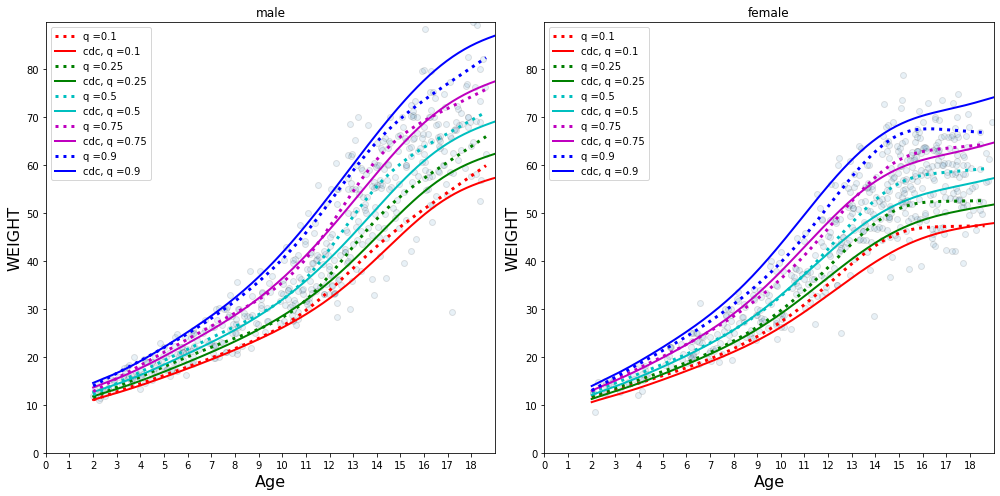

In [51]:
# Plot the results
print('Population comparison to cdc data on ' + response + ' using quantile regression')

cdc_df = cdc_df[cdc_df['Age']>=2]

plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           cdc_df = cdc_df,
           response=response)

In [52]:
# Import cdc data
# 2 to 20years
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/statage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]
# infants to 3 years
infile2  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/lenageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='HEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Population comparison to cdc data on HEIGHT using quantile regression
xstart:  0
xstart:  0


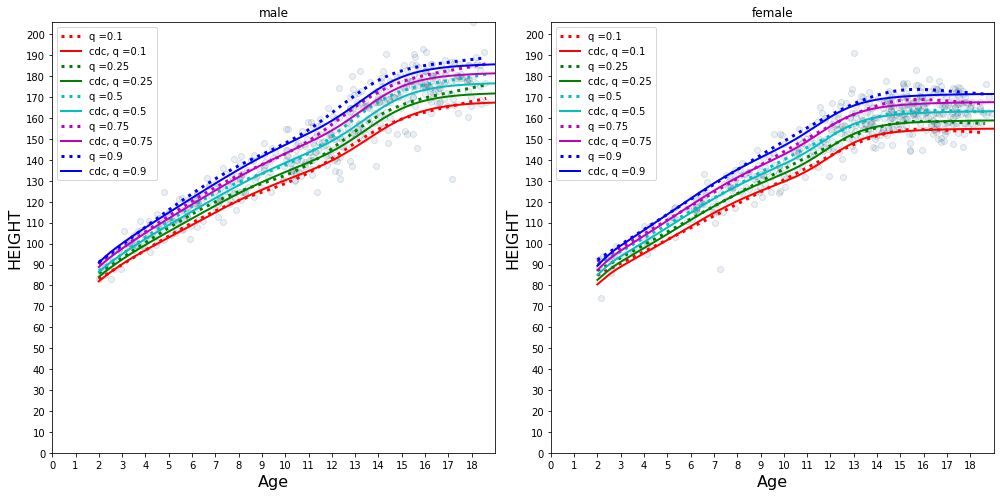

In [53]:
# Plot the results
if cdc_df is not None:
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    cdc_df = cdc_df[cdc_df['Age']>=2]
    
    plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               cdc_df = cdc_df,
               response=response)

In [54]:
# Import cdc data
# 2 to 20years
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/bmiage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

response='BMI_CALC'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Population comparison to cdc data on BMI_CALC using quantile regression
xstart:  0
xstart:  0


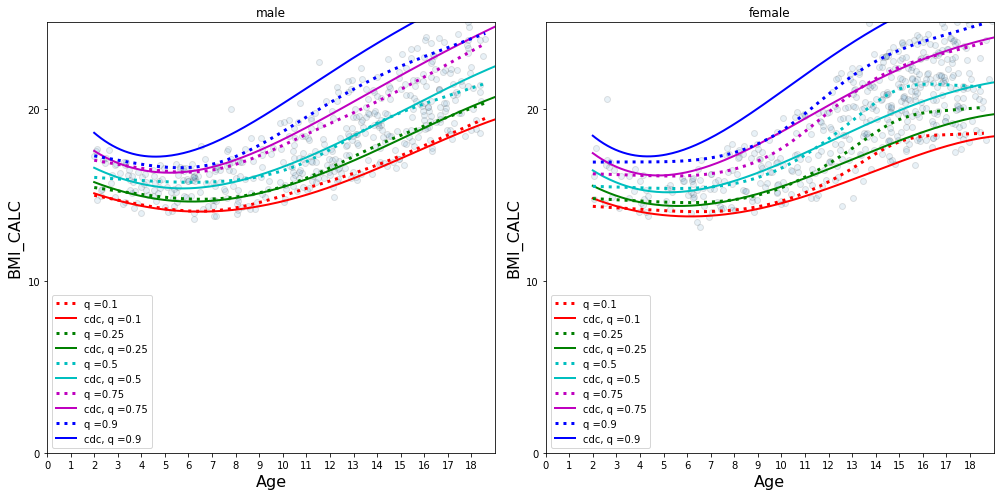

In [55]:
# Plot the results
if cdc_df is not None:
    cdc_df = cdc_df[cdc_df['Age']>=2]
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               cdc_df = cdc_df,
               response=response)

In [56]:
response='area_cm2'

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m, response)
model_f,knots_f = spline_model_optimizer_cr(df_f, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)
Total outliers:  103 Total points:  500
xstart:  0
Total outliers:  107 Total points:  512
xstart:  0


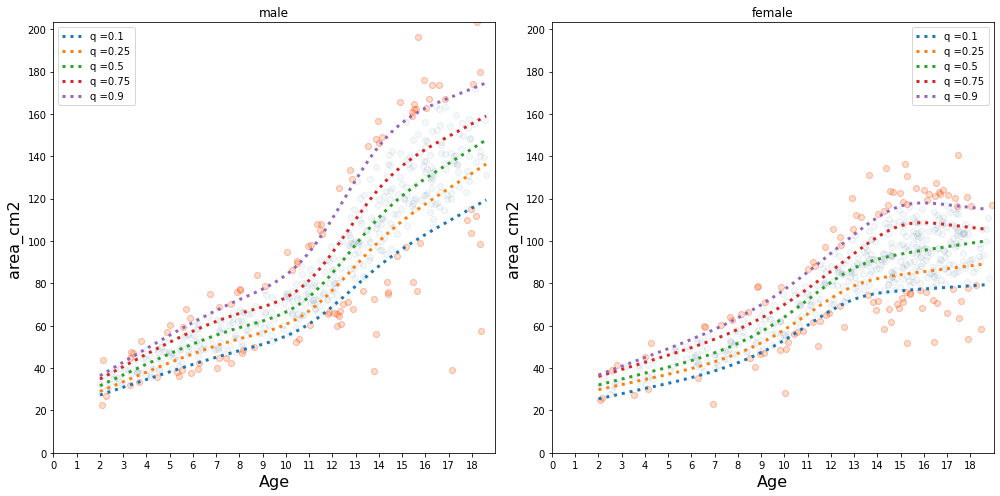

In [57]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)')
plot_bs_qr_cr([df_m,df_f],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response)

In [58]:
response='smi'

df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Quantile Regression with Splines for SMI [CCHMC data]
Total outliers:  101 Total points:  496
xstart:  0
Total outliers:  105 Total points:  507
xstart:  0


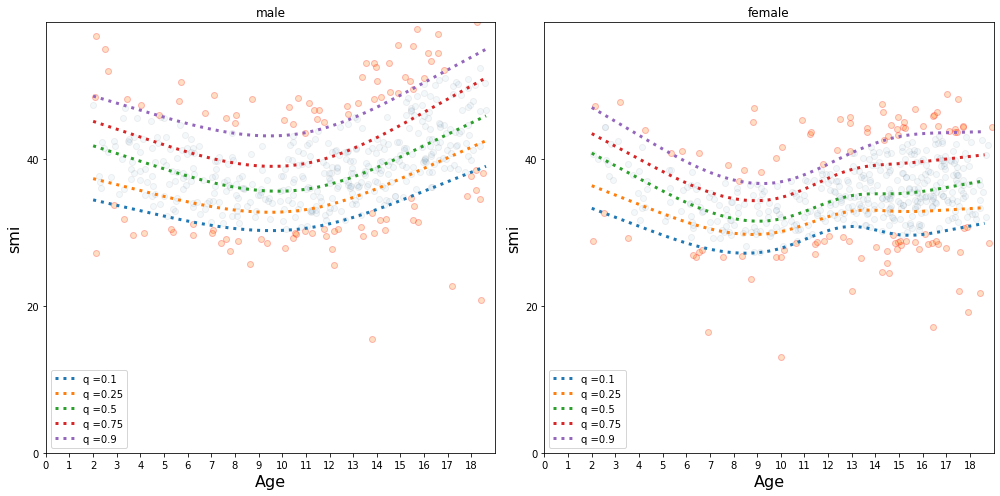

In [59]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data]')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response)

In [60]:
response='area_cm2'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Quantile Regression with Splines for SMA [CCHMC data] vs Weight
Total outliers:  101 Total points:  485
xstart:  10
Total outliers:  103 Total points:  505
xstart:  10


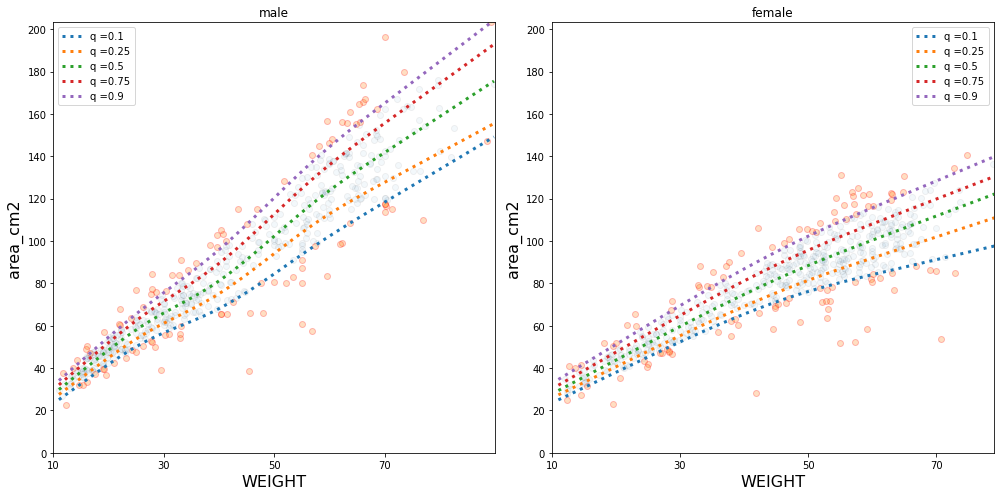

In [61]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs Weight')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response, predictor=predictor,xstart=10)

In [62]:
response='smi'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile Regression with Splines for SMI [CCHMC data] vs Weight
Total outliers:  100 Total points:  483
xstart:  10
Total outliers:  104 Total points:  503
xstart:  10


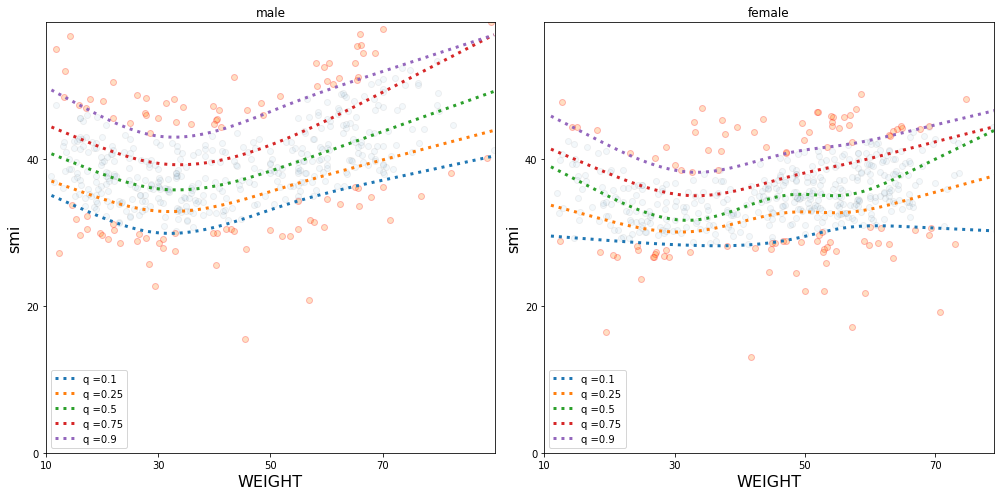

In [63]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs Weight')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor, xstart = 10)

In [64]:
response='area_cm2'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile Regression with Splines for SMA [CCHMC data] vs HEIGHT
Total outliers:  103 Total points:  496
xstart:  80
Total outliers:  105 Total points:  507
xstart:  80


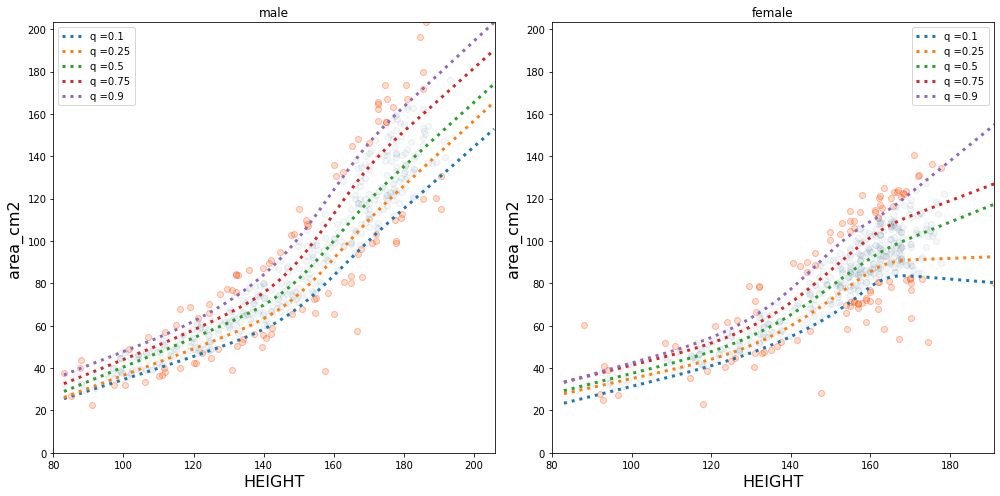

In [65]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs HEIGHT')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response,predictor=predictor, xstart=80)

In [66]:
response='smi'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Quantile Regression with Splines for SMI [CCHMC data] vs HEIGHT
Total outliers:  103 Total points:  496
xstart:  80
Total outliers:  106 Total points:  507
xstart:  80


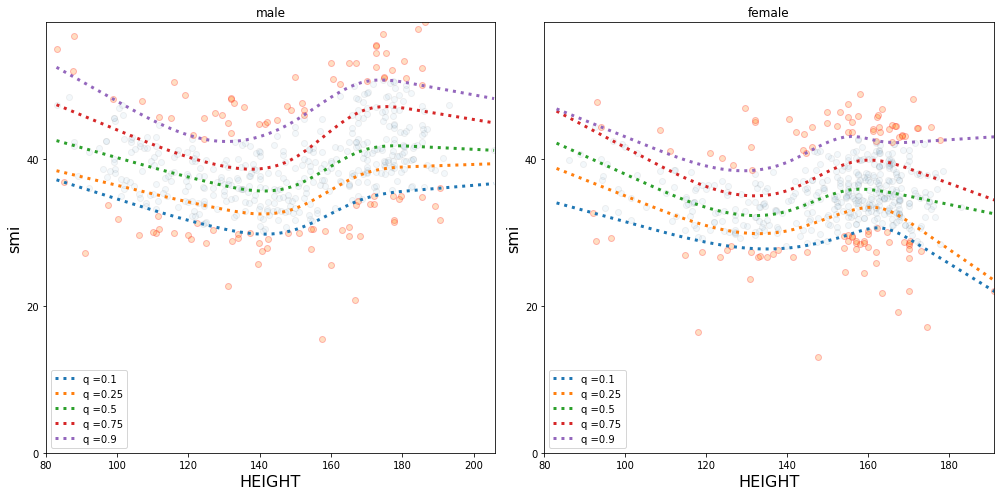

In [67]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs HEIGHT')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response, predictor=predictor, xstart=80)

In [68]:
response='area_cm2'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Quantile Regression with Splines for SMA [CCHMC data] vs BMI percentile
Total outliers:  103 Total points:  500
xstart:  0
Total outliers:  104 Total points:  512
xstart:  0


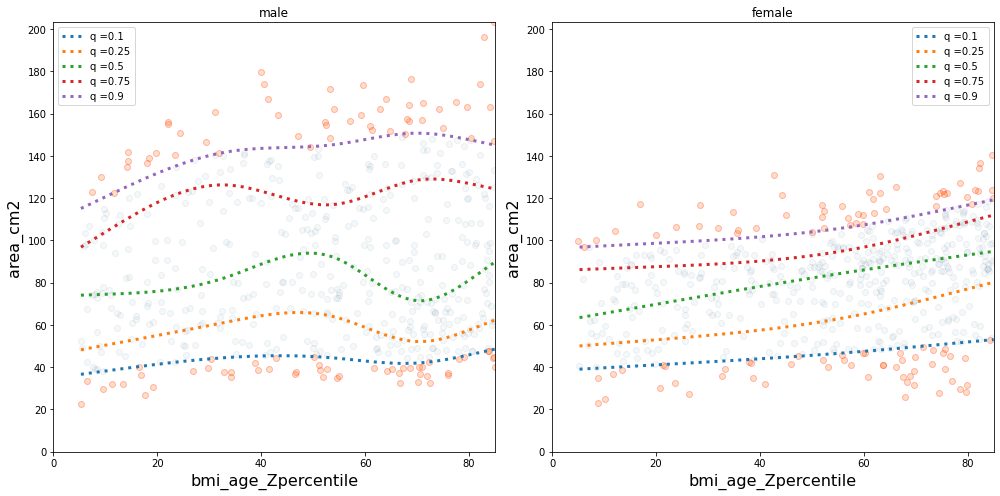

In [69]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs BMI percentile')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor)

In [70]:
response='smi'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Quantile Regression with Splines for SMI [CCHMC data] vs BMI percentile
Total outliers:  104 Total points:  496
xstart:  0
Total outliers:  105 Total points:  507
xstart:  0


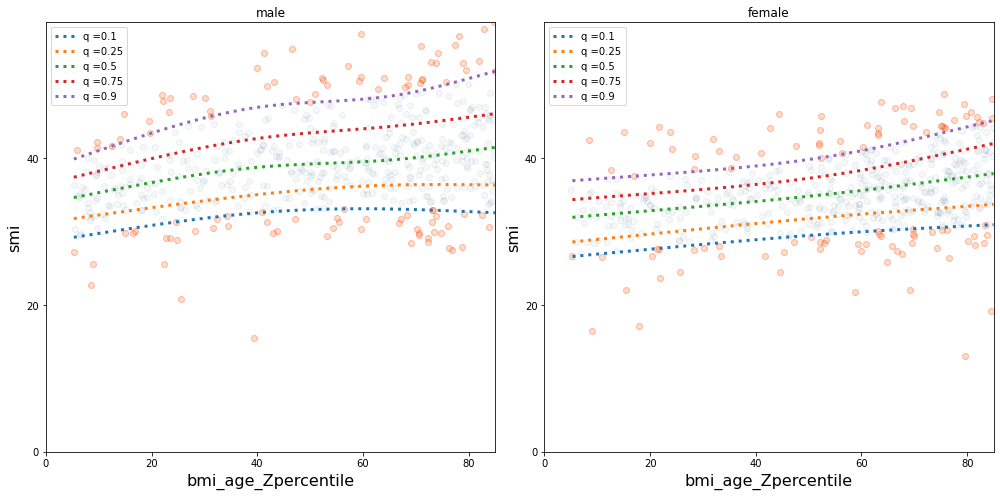

In [71]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs BMI percentile')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor)

In [72]:
response='area_cm2'
predictor='BMI_CALC'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m, qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f, qlist=[0.10,0.25,0.50,0.75,0.90])

Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI
Total outliers:  93 Total points:  443
xstart:  12
Total outliers:  100 Total points:  475
xstart:  12


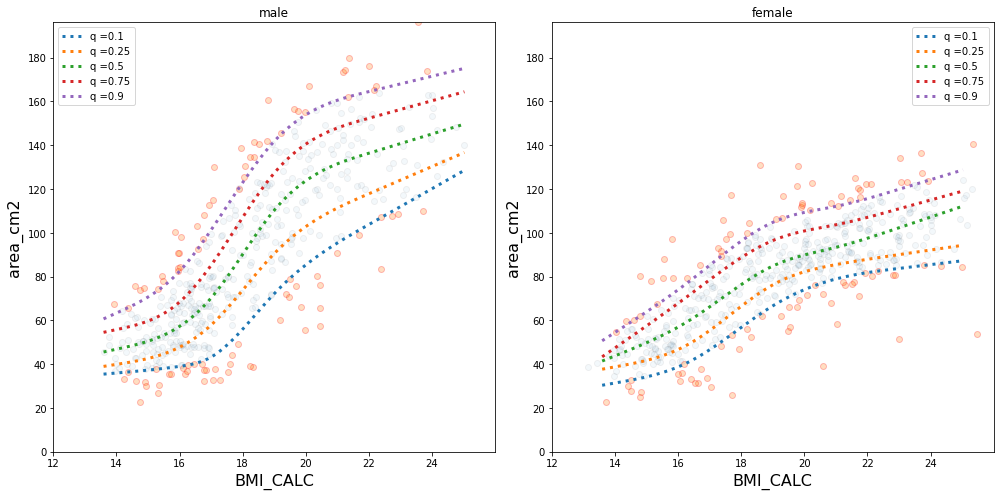

In [73]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor, xstart=12)

In [74]:
response='smi'
predictor='BMI_CALC'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI
Total outliers:  90 Total points:  440
xstart:  12
Total outliers:  97 Total points:  471
xstart:  12


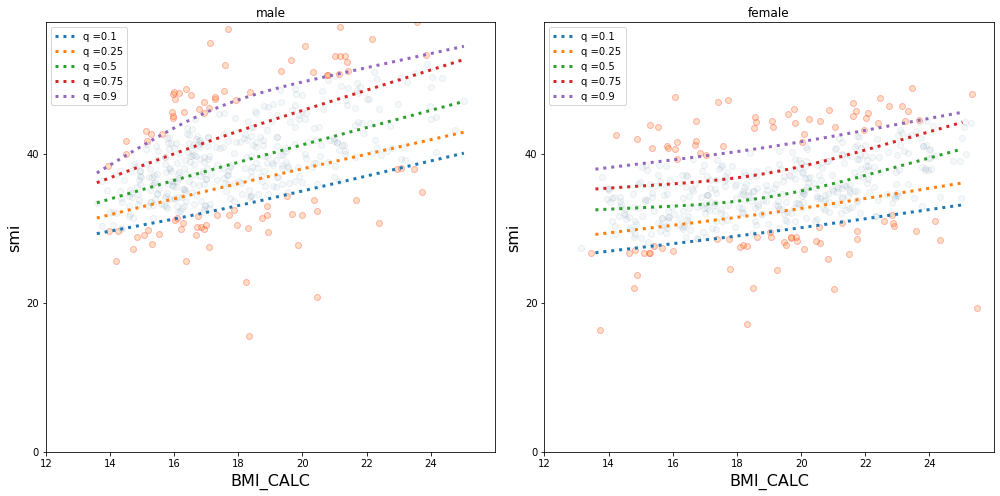

In [75]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response,predictor=predictor, xstart=12)